In [1]:
using EVQueues, Plots, Distributions
#using Pkg; Pkg.instantiate()

In [60]:
#Parámetros del resto de la simulación
lambda=100.0;
mu=1;
gamma=1;
C=40.0;
Tfinal=100.0;

#Se agrega snaps para hacer animaciones
#snaps = collect(0.1:0.1:Tfinal);

Simulando... 100%|██████████████████████████████████████| Time: 0:00:00


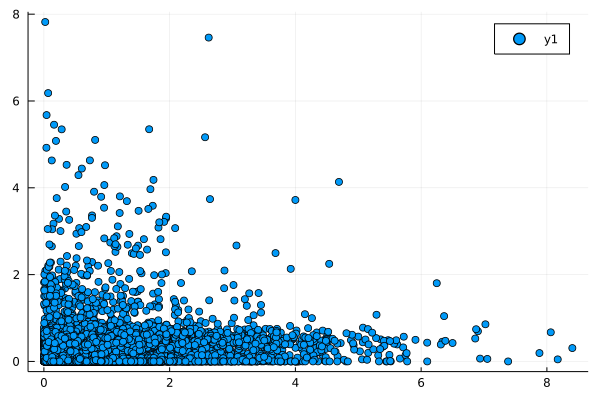

In [61]:
function hybridpolicy(evs,C::Float64)
    #Asigno el 70% de la potencia para EDF y el 30% para FIFO (asumo que el 30% no reportan deadline)
    C_edf=0.7*C;
    C_fifo=0.3*C;
    
    if length(evs)==0
        #nothing to do, return empty array for consistence
        U=Array{Float64}(undef,0);
    else
        p=0.0;
        p_fifo=0.0;
        p_edf=0.0;        
        i=1;
        U=zeros(length(evs));
        
        deadlines = [ev.currentReportedDeadline for ev in evs];
        perm = sortperm(deadlines);
        
        while p<C && i<=length(evs)
            #Si no reporta deadline aplico FIFO
            if deadlines[i] == Inf
                alloc = min(evs[i].chargingPower,C_fifo-p_fifo);
                p_fifo=p_fifo+alloc;
                U[i]=alloc;
            #Si reporta deadline aplico EDF
            else
                alloc = min(evs[perm[i]].chargingPower,C_edf-p_edf);
                p_edf=p_edf+alloc;
                U[perm[i]]=alloc;
            end
            i=i+1
            p=p_fifo+p_edf
        end
    end
    return U;
end


df = generate_Poisson_stream(lambda,mu,gamma,Tfinal);

#El 30% de los usuarios no reportan deadline
function no_deadline()
    random = rand()
    if random<0.3
        return Inf
    else
        return 0
    end
end
reportedDeadlines = [d+no_deadline() for d in df[!,:salidas]]
df[:salidaReportada] = reportedDeadlines

hybrid_policy = ev_sim_trace(df,hybridpolicy,C,[Inf]);
compute_statistics!(hybrid_policy);

hybrid_policy_evs = sort(hybrid_policy.EVs,by=ev->ev.arrivalTime)

#para recortar el transitorio
n=Int(Tfinal*lambda/10);
hybrid_policy_evs = hybrid_policy_evs[n:end-n]

#Guardo resultados de vehiculos
S = [ev.requestedEnergy for ev in hybrid_policy_evs];
Sr = [ev.departureWorkload for ev in hybrid_policy_evs];
Sa = S_alg - Sr_alg

scatter(S,Sa)

